In [22]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from PyHa.annotation_post_processing import annotation_chunker
from PyHa.template_matching.utils import generate_specgram, butter_bandpass, filter
import librosa
import os
import matplotlib.pyplot as plt

## Loading in the Human verified Data from AM 1 

In [23]:
labeled_df = pd.read_csv("sustech_csvs_labeled/GRABADOR-SDZG-AM-1_ATTILLA_single_w_confidences.csv")
labeled_df

,FOLDER,IN FILE,CHANNEL,CLIP LENGTH,SAMPLE RATE,OFFSET,MANUAL ID,DURATION,CONFIDENCE
0,/media/thesis-generator/Audio UCSD/CARPETA-GRA...,20190616_183000.WAV,0,60.0,8000,58.148250,ATTILLA_0,1.851750,0.188168
1,/media/thesis-generator/Audio UCSD/CARPETA-GRA...,20190616_195000.WAV,0,60.0,8000,31.640125,ATTILLA_0,2.000000,0.182193
2,/media/thesis-generator/Audio UCSD/CARPETA-GRA...,20190616_202000.WAV,0,60.0,8000,25.444250,ATTILLA_0,4.235625,0.222829
3,/media/thesis-generator/Audio UCSD/CARPETA-GRA...,20190616_220000.WAV,0,60.0,8000,4.173875,ATTILLA_0,2.000000,0.180312
4,/media/thesis-generator/Audio UCSD/CARPETA-GRA...,20190616_173000.WAV,0,60.0,8000,32.662125,ATTILLA_0,3.533000,0.185319
...,...,...,...,...,...,...,...,...,...
1065,/media/thesis-generator/Audio UCSD/CARPETA-GRA...,20190705_172000.WAV,0,60.0,8000,58.276000,ATTILLA_0,1.724000,0.223701
1066,/media/thesis-generator/Audio UCSD/CARPETA-GRA...,20190708_181000.WAV,0,60.0,8000,3.790625,ATTILLA_0,2.191625,0.205309
1067,/media/thesis-generator/Audio UCSD/CARPETA-GRA...,20190708_181000.WAV,0,60.0,8000,6.473375,ATTILLA_0,2.000000,0.204205
1068,/media/thesis-generator/Audio UCSD/CARPETA-GRA...,20190708_181000.WAV,0,60.0,8000,23.975125,ATTILLA_0,2.000000,0.205538


## Normalizing to 3s annotations

In [24]:
#labeled_df = annotation_chunker(labeled_df, 3)

In [25]:
#labeled_df.to_csv("attilla_am1_normalized.csv", index=False)

## Acquiring Labels

In [26]:
id = "ATTILLA"
y = np.zeros(len(labeled_df))
for row in labeled_df.index:
    if labeled_df["MANUAL ID"][row] == id+"_1":
        y[row] = 1
print(y.shape)

(1070,)


## Acquiring Feature Vectors

(24000,)
(128, 47)
(6016,)


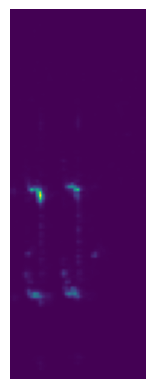

In [29]:
# generating the initial specgram to know the size
sample_rate = labeled_df["SAMPLE RATE"][1].item()
init_clip, _ = librosa.load(os.path.join(labeled_df["FOLDER"][1],labeled_df["IN FILE"][1]), sr=sample_rate, offset=labeled_df["OFFSET"][1], duration=3)
print(init_clip.shape)
#init_spec = generate_specgram(init_clip, sample_rate)
init_spec = librosa.feature.melspectrogram(y=init_clip, sr=sample_rate)
plt.imshow(init_spec)
plt.axis('off')
print(init_spec.shape)
init_spec = init_spec.flatten()
print(init_spec.shape)

## Initializing the bandpass filter

In [7]:
isolation_parameters = {
    "model" : "template_matching",
    # we will be modifying this for each path
    "template_path" : "",
    "technique" : "steinberg",
    # ideally this is the length of the template in seconds
    "window_size" : 2.0,
    "threshold_type" : "pure",
    "threshold_const" : 0.18,
    "cutoff_freq_low" : 1000,
    "cutoff_freq_high" : 3500,
    "verbose" : True,
    "write_confidence" : True
}
# creating the bandpass filter
b, a = butter_bandpass(isolation_parameters['cutoff_freq_low'], 
                       isolation_parameters['cutoff_freq_high'], sample_rate, order=10)

In [8]:
x = np.zeros((len(labeled_df),init_spec.shape[0]))
print(x.shape)
for row in labeled_df.index:
    cur_path = labeled_df["IN FILE"][row]
    cur_offset = labeled_df["OFFSET"][row]
    if cur_offset > 57:
        continue
    #cur_dur = labeled_df["DURATION"][row]
    cur_clip, _ = librosa.load(cur_path, sr=sample_rate, offset=cur_offset, duration=3)
    cur_clip = filter(cur_clip, b, a)
    cur_mel_spec = librosa.feature.melspectrogram(y=cur_clip, sr=sample_rate)
    cur_mel_spec = cur_mel_spec.flatten()
    x[row,:] = cur_mel_spec

(2109, 6016)


## Training a linear SVM Classifier

In [9]:
from sklearn.svm import LinearSVC
lin_svm = LinearSVC()
lin_svm.fit(x, y)

/home/thesis-generator/PyHa/.venv/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

## Training a Radial SVM Classifier

In [10]:
from sklearn import svm
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.fit(x,y)

SVC()

## Training a Kernelized k-Nearest-Neighbor Classifier

In [11]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(weights='distance')
knn.fit(x,y)

KNeighborsRegressor(weights='distance')

# Training a Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x,y)

RandomForestClassifier()

## Training a Regularized Logistic Regression Classifier

In [13]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(x,y)

LogisticRegression()

## Quick sanity check by predicting on the training data
### Not reported in paper

In [14]:
y_lin_svm = lin_svm.predict(x)
y_rbf_svc = rbf_svc.predict(x)
y_knn = knn.predict(x)
y_rf = rf.predict(x)
y_log_reg = log_reg.predict(x)

In [15]:
acc_lin_svm = np.sum(y_lin_svm == y)/y.shape[0]
acc_rbf_svc = np.sum(y_rbf_svc == y)/y.shape[0]
acc_knn = np.sum(y_knn == y)/y.shape[0]
acc_rf = np.sum(y_rf == y)/y.shape[0]
acc_log_reg = np.sum(y_log_reg == y)/y.shape[0]
print("Linear SVM Sanity Acc: ", round(acc_lin_svm,4))
print("Radial SVM Sanity Acc: ", round(acc_rbf_svc,4))
print("Kernelized k-Nearest-Neighbor Sanity Acc: ", round(acc_knn,4))
print("Random Forest Sanity Acc: ", round(acc_rf,4))
print("Logistic Regression Sanity Acc: ", round(acc_log_reg,4))

Linear SVM Sanity Acc:  0.8383
Radial SVM Sanity Acc:  0.6899
Kernelized k-Nearest-Neighbor Sanity Acc:  0.8549
Random Forest Sanity Acc:  0.9995
Logistic Regression Sanity Acc:  0.7568


## Loading in the test data from AM 3, has been processed the same way AM 1 was processed, however, it is unlabeled

In [16]:
unlabeled_df = pd.read_csv("sustech_csvs/GRABADOR-SDZG-AM-3_ATTILLA_single_w_confidences.csv")
unlabeled_df = annotation_chunker(unlabeled_df, 3)

## Computing the Feature Vectors of the Unlabeled Data

In [17]:
x_unknown = np.zeros((len(unlabeled_df), init_spec.shape[0]))
print(x_unknown.shape)
for row in unlabeled_df.index:
    cur_path = unlabeled_df["IN FILE"][row]
    cur_offset = unlabeled_df["OFFSET"][row]
    cur_dur = unlabeled_df["DURATION"][row]
    cur_clip, _ = librosa.load(cur_path, sr=sample_rate, offset=cur_offset, duration=cur_dur)
    cur_clip = filter(cur_clip, b, a)
    cur_mel_spec = librosa.feature.melspectrogram(y=cur_clip, sr=sample_rate)
    cur_mel_spec = cur_mel_spec.flatten()
    x_unknown[row,:] = cur_mel_spec

(2032, 6016)


## Running all the models on the unlabeled feature vectors

In [18]:
models = [lin_svm, rbf_svc, knn, rf, log_reg]
classification_votes = np.zeros((x_unknown.shape[0],))
for model in models:
    cur_classification = model.predict(x_unknown)
    classification_votes += cur_classification

## Majority Vote

In [19]:
ensemble_class_prediction = classification_votes >= 3
print(ensemble_class_prediction.shape)

(2032,)


## Filtering out the clips without a consensus

In [20]:
ensemble_df = unlabeled_df
ensemble_df["MANUAL ID"] = ensemble_class_prediction
ensemble_df = ensemble_df[ensemble_df["MANUAL ID"] == 1]
print(len(ensemble_df))

1221


In [21]:
# hacky fix for now until the annotation chunker "FOLDER" is fixed
ensemble_df["FOLDER"] = [''] * len(ensemble_df)
ensemble_df.to_csv("sustech_csvs/ensemble_attilla_am3_alt.csv", index=False)

/tmp/ipykernel_313910/25306614.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ensemble_df["FOLDER"] = [''] * len(ensemble_df)
